In [25]:
import torch 
import numpy as np 
import pandas as pd
import sys
sys.path.append("/binf-isilon/renniegrp/vpx267/ucph_thesis/")
from wrapper.utils import plot_correlation
from model import TestMotifModel
from wrapper import utils
from torch.utils.data import DataLoader
from wrapper.data_setup import SequenceDatasetDual
import matplotlib.pyplot as plt

In [37]:
fold = 1
batch_size = 128
data_folder = "/binf-isilon/renniegrp/vpx267/ucph_thesis/data/dual_outputs"

seq_fasta_train_path = f"{data_folder}/motif_fasta_train_SPLIT_{fold}.fasta"
meta_data_train_json_path = f"{data_folder}/train_meta_data_SPLIT_{fold}.json"
train_dataset = SequenceDatasetDual(seq_fasta_path=seq_fasta_train_path, meta_data_path=meta_data_train_json_path)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

seq_fasta_test_path = f"{data_folder}/motif_fasta_test_SPLIT_{fold}.fasta"
meta_data_test_json_path = f"{data_folder}/test_meta_data_SPLIT_{fold}.json"
test_dataset = SequenceDatasetDual(seq_fasta_path=seq_fasta_test_path, meta_data_path=meta_data_test_json_path)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model_weight = torch.load(f"/binf-isilon/renniegrp/vpx267/ucph_thesis/data/outputs/models/trained_model_{fold}th_fold_dual_outputs_m6_info-no_promoter-False_MOTIF.pkl",
                        map_location=torch.device('cpu'))
config = {'cnn_first_filter': 16, 'cnn_first_kernel_size': 9, 'cnn_length': 3, 'cnn_filter': 32, 'cnn_kernel_size': 7, 'bilstm_layer': 3, 'bilstm_hidden_size': 128, 'fc_size': 64}            
model = TestMotifModel(input_channel=4, cnn_first_filter=config["cnn_first_filter"], cnn_first_kernel_size=config["cnn_first_kernel_size"],
                        cnn_other_filter=config["cnn_filter"], cnn_other_kernel_size=config["cnn_kernel_size"], bilstm_layer=config["bilstm_layer"], bilstm_hidden_size=config["bilstm_hidden_size"], fc_size=config["fc_size"],
                        output_size=2)
model.load_state_dict(model_weight)
model.eval()

device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))
model.to(device)
model.eval()

/binf-isilon/renniegrp/vpx267/miniconda3/envs/thesis_ray_gpu/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TestMotifModel(
  (CNN): Sequential(
    (CNN_1): Conv1d(4, 16, kernel_size=(9,), stride=(1,), padding=same)
    (RELU_1): ReLU()
    (DROPOUT_1): Dropout(p=0.2, inplace=False)
    (BATCHNORM_1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MAX_POOL_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (CNN_2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=same)
    (RELU_2): ReLU()
    (BATCHNORM_2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MAX_POOL_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (CNN_3): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=same)
    (RELU_3): ReLU()
    (BATCHNORM_3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (MAX_POOL_3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (biLSTM): LSTM(32, 128, num_layers=3, batch_first=Tru

In [45]:
device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))
model.to(device)
model.eval()

train_pred= torch.Tensor().to("cpu", non_blocking=True)
train_true = torch.Tensor().to("cpu", non_blocking=True)

for train_data in train_loader:
    seq = train_data["seq"].to(device, non_blocking=True)
    meth_true_val = torch.stack([train_data[f"meth_control"].to(device, non_blocking=True), 
                                    train_data[f"meth_case"].to(device, non_blocking=True)], dim=1)
    meth_pred_val = model(seq)
    train_pred = torch.cat([train_pred, meth_pred_val.cpu().detach()])
    train_true = torch.cat([train_true, meth_true_val.cpu().detach()])

true_control = train_true[:,0]
true_case = train_true[:,1]
pred_control = train_pred[:,0]
pred_case = train_pred[:,1]

model.cpu()
train_validation_df = pd.DataFrame({"true_control": true_control, "true_case": true_case, "pred_control": pred_control, "pred_case": pred_case})

del train_pred, train_true, meth_true_val, meth_pred_val, seq, true_control, true_case, pred_control, pred_case

In [46]:
device = (torch.device("cuda") if torch.cuda.is_available()
            else torch.device("cpu"))
model.to(device)
model.eval()

test_pred= torch.Tensor().to("cpu", non_blocking=True)
test_true = torch.Tensor().to("cpu", non_blocking=True)

for test_data in test_loader:
    seq = test_data["seq"].to(device, non_blocking=True)
    meth_true_val = torch.stack([test_data[f"meth_control"].to(device, non_blocking=True), 
                                    test_data[f"meth_case"].to(device, non_blocking=True)], dim=1)
    meth_pred_val = model(seq)
    test_pred = torch.cat([test_pred, meth_pred_val.cpu().detach()])
    test_true = torch.cat([test_true, meth_true_val.cpu().detach()])

true_control = test_true[:,0]
true_case = test_true[:,1]
pred_control = test_pred[:,0]
pred_case = test_pred[:,1]

model.cpu()
test_validation_df = pd.DataFrame({"true_control": true_control, "true_case": true_case, "pred_control": pred_control, "pred_case": pred_case})
del test_pred, test_true, meth_true_val, meth_pred_val, seq, true_control, true_case, pred_control, pred_case

In [73]:
train_validation_df["true_control_bin"] = pd.cut(train_validation_df["true_control"], bins=100, labels=np.arange(100))
train_validation_df["true_case_bin"] = pd.cut(train_validation_df["true_case"], bins=100, labels=np.arange(100))
test_validation_df["true_control_bin"] = pd.cut(test_validation_df["true_control"], bins=100, labels=np.arange(100))
test_validation_df["true_case_bin"] = pd.cut(test_validation_df["true_case"], bins=100, labels=np.arange(100))
print(train_validation_df)

        true_control  true_case  pred_control  pred_case true_control_bin  \
0             0.3976     0.0000      0.610820   0.557982               39   
1             0.3564     0.6158      0.568423   0.580558               35   
2             0.1444     0.1853      0.305591   0.175913               14   
3             0.2182     0.2208      0.293539   0.165499               21   
4             0.0000     0.1080      0.258205   0.225950                0   
...              ...        ...           ...        ...              ...   
103850        0.1837     0.0000      0.243598   0.106746               18   
103851        0.9804     0.9896      0.750631   0.631827               98   
103852        0.3638     0.0000      0.297644   0.244975               36   
103853        0.2810     0.0000      0.274804   0.226825               28   
103854        0.0000     0.3137      0.355755   0.301590                0   

       true_case_bin  
0                  0  
1                 61  
2     

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

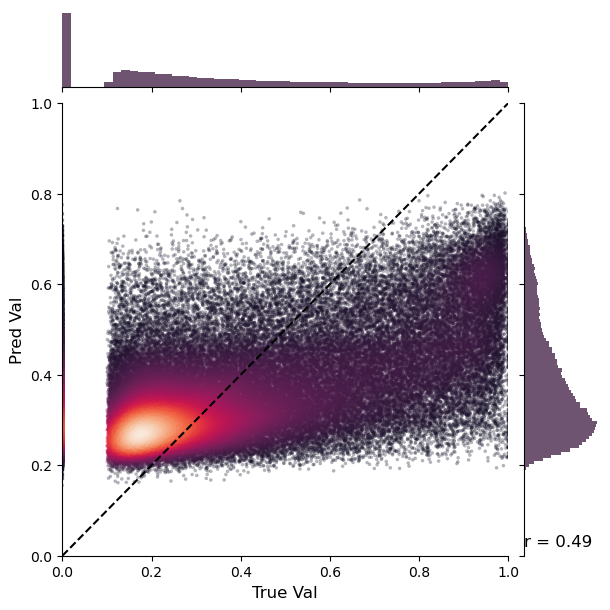

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

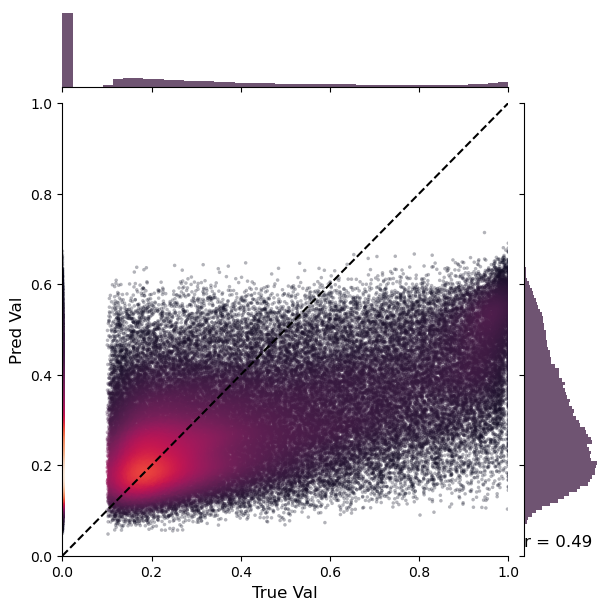

In [47]:
plot_correlation(train_validation_df["true_control"], train_validation_df["pred_control"], title="Train Control Data", interactive=True)
plot_correlation(train_validation_df["true_case"], train_validation_df["pred_case"], title="Train Case Data", interactive=True)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

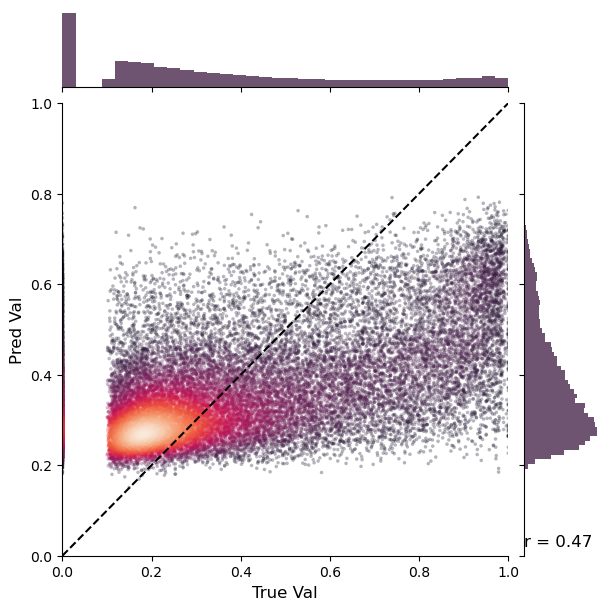

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

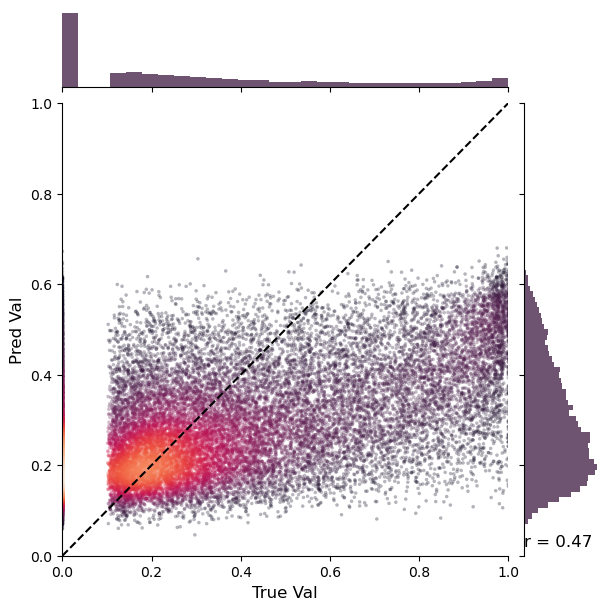

In [48]:
plot_correlation(test_validation_df["true_control"], test_validation_df["pred_control"], title="Test Control Data", interactive=True)
plot_correlation(test_validation_df["true_case"], test_validation_df["pred_case"], title="Test Case Data", interactive=True)

In [74]:
train_control_mse = ((train_validation_df["true_control"] - train_validation_df["pred_control"])**2)
train_control_mse_binned = pd.cut(train_control_mse, bins=100, labels=np.arange(100))
train_case_mse = ((train_validation_df["true_case"] - train_validation_df["pred_case"])**2)
train_case_mse_binned = pd.cut(train_case_mse, bins=100, labels=np.arange(100))

test_control_mse = ((test_validation_df["true_control"] - test_validation_df["pred_control"])**2)
test_control_mse_binned = pd.cut(test_control_mse, bins=100, labels=np.arange(100))
test_case_mse = ((test_validation_df["true_case"] - test_validation_df["pred_case"])**2)
test_case_mse_binned = pd.cut(test_case_mse, bins=100, labels=np.arange(100))

Text(0.5, 0.98, 'Fold1 Training MSE Distribution')

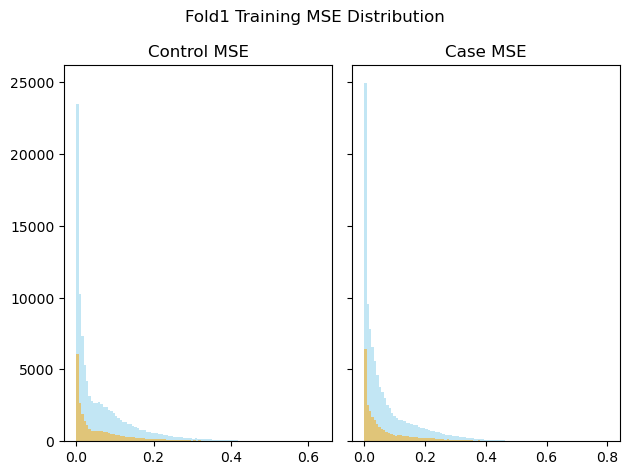

In [49]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(train_control_mse, bins=100, alpha=.5, color = "skyblue")
axs[0].hist(test_control_mse, bins=100, alpha=.5, color = "orange")
axs[0].set_title("Control MSE")
axs[1].hist(train_case_mse, bins=100, alpha=.5, color = "skyblue")
axs[1].hist(test_case_mse, bins=100, alpha=.5, color = "orange")
axs[1].set_title("Case MSE")
fig.suptitle(f"Fold{fold} Training MSE Distribution")

Text(0.5, 0.98, 'Error Correlation Between Bin Size and MSE (Hypoxia Data)\n(Fold = 1, R = -0.026)')

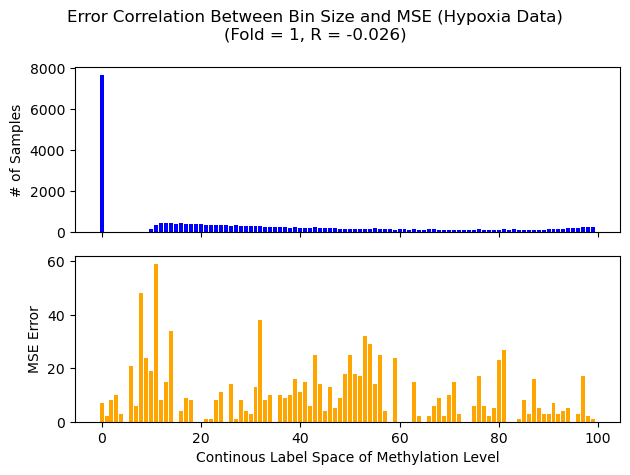

In [129]:
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True)

num_sample = test_validation_df["true_case_bin"].cat.codes.value_counts().sort_index().reindex(range(100), fill_value=0)
axs[0].bar(np.arange(0,100), num_sample, color='blue')
axs[0].set_ylabel("# of Samples")
# axs[0].set_title("Test Data Distribution")
# axs[1].hist(test_validation_df["true_case_bin"], weights=weights, bins=100, alpha=.8, color = "orange")
mse = test_case_mse_binned.cat.codes.sort_index().reindex(range(100), fill_value=0)
axs[1].bar(np.arange(0,100), mse, color='orange')
axs[1].set_ylabel("MSE Error")
axs[1].set_xlabel("Continous Label Space of Methylation Level")
fig.suptitle(f"Error Correlation Between Bin Size and MSE (Hypoxia Data)\n(Fold = {fold}, R = {np.corrcoef(num_sample, mse)[0,1]:.3f})")

Text(0.5, 0.98, 'Error Correlation Between Bin Size and MSE (Control Data)\n(Fold = 1, R = 0.059)')

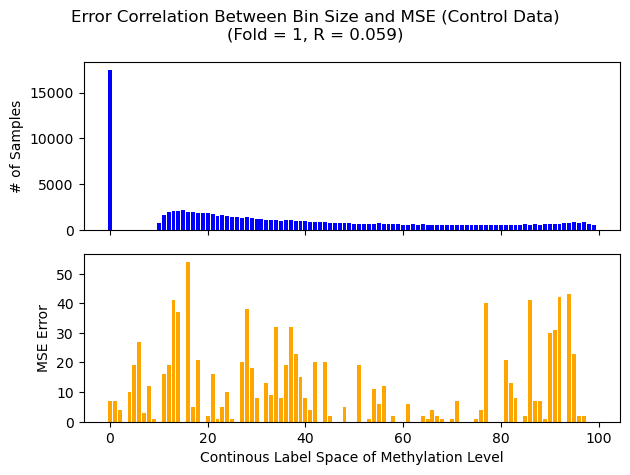

In [132]:
fig, axs = plt.subplots(2, 1, sharex=True, tight_layout=True)

num_sample = train_validation_df["true_control_bin"].cat.codes.value_counts().sort_index().reindex(range(100), fill_value=0)
axs[0].bar(np.arange(0,100), num_sample, color='blue')
axs[0].set_ylabel("# of Samples")
mse = train_control_mse_binned.cat.codes.sort_index().reindex(range(100), fill_value=0)
axs[1].bar(np.arange(0,100), mse, color='orange')
axs[1].set_ylabel("MSE Error")
axs[1].set_xlabel("Continous Label Space of Methylation Level")
fig.suptitle(f"Error Correlation Between Bin Size and MSE (Control Data)\n(Fold = {fold}, R = {np.corrcoef(num_sample, mse)[0,1]:.3f})")

In [153]:
temp_df = pd.DataFrame({"test_control_mse":test_control_mse, "test_control_mse_binned":test_control_mse_binned.cat.codes.sort_index()})
temp_df.groupby("test_control_mse_binned").sum()

,test_control_mse
test_control_mse_binned,
0,12.941394
1,25.014042
2,29.746899
3,30.944149
4,32.037022
...,...
91,1.152587
95,0.598327
96,0.607230


0        0.024324
1        0.000773
2        0.033294
3        0.008468
4        0.011403
           ...   
27478    0.007881
27479    0.052619
27480    0.002461
27481    0.223678
27482    0.003287
Length: 27483, dtype: float32

In [140]:
test_validation_df["true_case_bin"].cat.codes.value_counts().sum()

27483

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[10  7  6 10  8 11 14  5  8  9 12  8 13  7  8 13 18 13  6 11 10  8 11  7
  4  6 12 10 14  7  7 15 10 10  5 13 11 13  7 11  8 12 15 10  8  9 12 21
 12 10  6 11  9  9  7  8 10  8 11  8 12  9 12  7 11 16 10 10 10  6  8  9
  8  9  6 10 11  5  8 12  8  8 10 17 13 10  9  7  7 11 13  8 13 12 11  7
 10  9  9 14]


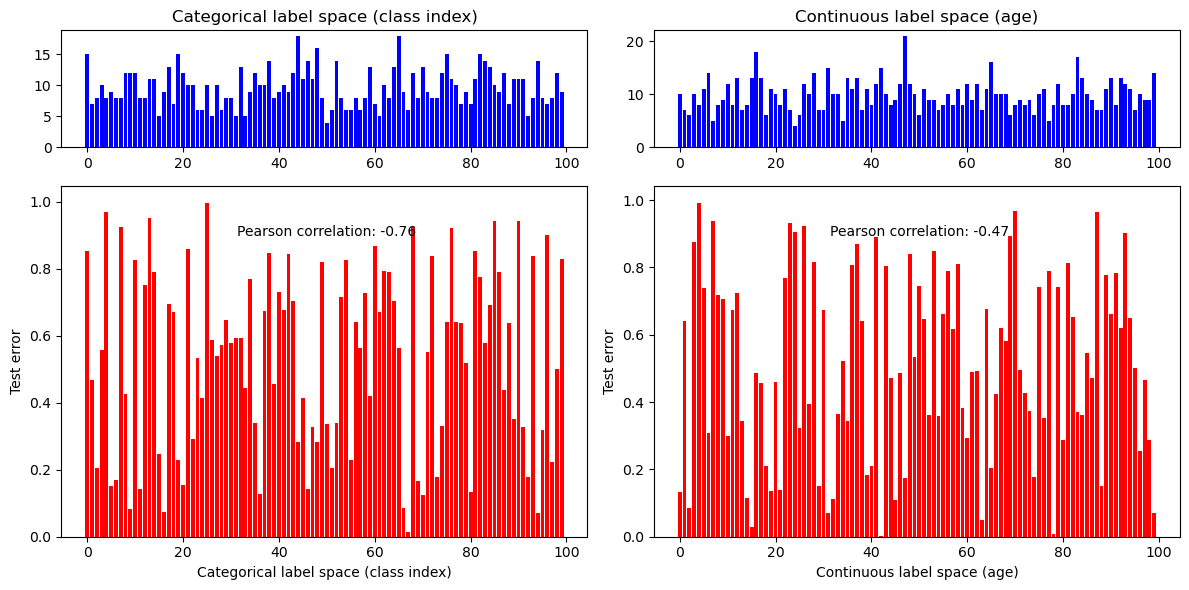

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy data - replace this with your actual data
class_indices = np.arange(100)
age_bins = np.arange(100)
sample_counts_categorical = np.random.poisson(lam=10, size=100)
sample_counts_continuous = np.random.poisson(lam=10, size=100)
test_error_categorical = np.random.rand(100)
test_error_continuous = np.random.rand(100)
print(age_bins)
print(sample_counts_continuous)
# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [1, 3]})

# Top left histogram for categorical data
axes[0, 0].bar(class_indices, sample_counts_categorical, color='blue')
axes[0, 0].set_title('Categorical label space (class index)')

# Bottom left bar plot for categorical test error
axes[1, 0].bar(class_indices, test_error_categorical, color='red')
axes[1, 0].set_xlabel('Categorical label space (class index)')
axes[1, 0].set_ylabel('Test error')

# Top right histogram for continuous data
axes[0, 1].bar(age_bins, sample_counts_continuous, color='blue')
axes[0, 1].set_title('Continuous label space (age)')

# Bottom right bar plot for continuous test error
axes[1, 1].bar(age_bins, test_error_continuous, color='red')
axes[1, 1].set_xlabel('Continuous label space (age)')
axes[1, 1].set_ylabel('Test error')

# Add correlation text
axes[1, 0].text(50, np.max(test_error_categorical) * 0.9, 'Pearson correlation: -0.76', ha='center')
axes[1, 1].text(50, np.max(test_error_continuous) * 0.9, 'Pearson correlation: -0.47', ha='center')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Text(0.5, 0.98, 'Fold1 Test Data Distribution')

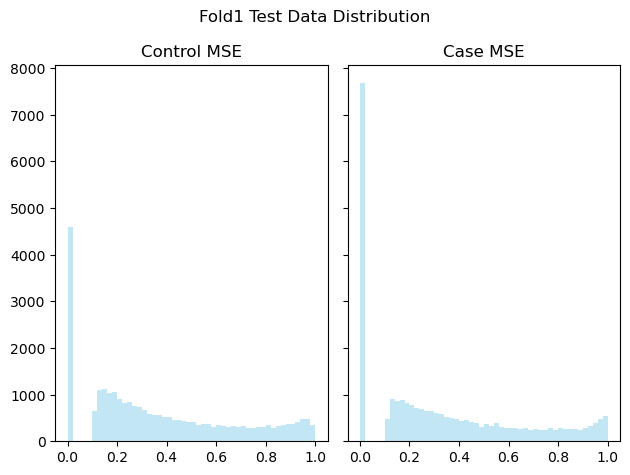

In [51]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(test_validation_df["true_control"], bins=50, alpha=.5, color = "skyblue")
axs[0].set_title("Control MSE")
axs[1].hist(test_validation_df["true_case"], bins=50, alpha=.5, color = "skyblue")
axs[1].set_title("Case MSE")
fig.suptitle(f"Fold{fold} Test Data Distribution")

Text(0.5, 0.98, 'Fold1 Test Data Distribution')

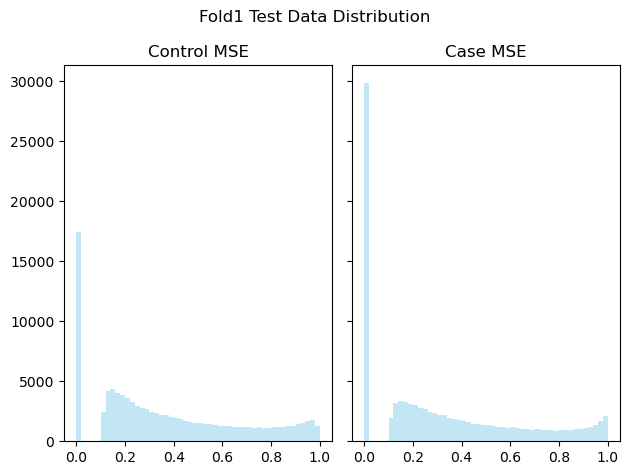

In [52]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(train_validation_df["true_control"], bins=50, alpha=.5, color = "skyblue")
axs[0].set_title("Control MSE")
axs[1].hist(train_validation_df["true_case"], bins=50, alpha=.5, color = "skyblue")
axs[1].set_title("Case MSE")
fig.suptitle(f"Fold{fold} Test Data Distribution")

TRY TO BINNING DATA TO GET THE CORRELATION BETWEEN NUMBER oF DATA ON EACH BIN AND THE ERROR 

In [54]:
import numpy as np

# Let's assume data is your array
data = np.random.rand(1000)  # generate 1000 random numbers in the range 0-1

hist, bin_edges = np.histogram(data, bins=50, range=(0, 1))

print(hist)
print(bin_edges)

[18 23 22 22 21 14 12 13 23 22 18 17 23 22 19 22 18 20 21 22 16 23 17 19
 17 20 17 11 24 25 25 21 24 21 20 23 18 27 15 23 20 24 24 28 14 19 12 24
 22 15]
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


In [58]:
test_validation_df

,true_control,true_case,pred_control,pred_case
0,0.1250,0.0000,0.280962,0.246335
1,0.6414,0.6398,0.613604,0.510280
2,0.1932,0.0000,0.375667,0.259788
3,0.3377,0.6667,0.429724,0.387682
4,0.3794,0.6644,0.486184,0.499197
...,...,...,...,...
27478,0.3173,0.0000,0.406077,0.378882
27479,0.0000,0.1382,0.229388,0.093505
27480,0.4722,0.0000,0.422588,0.408584
27481,0.7765,0.6825,0.303554,0.196533


In [64]:
test_validation_df

,true_control,true_case,pred_control,pred_case,true_control_bin,true_case_bin
0,0.1250,0.0000,0.280962,0.246335,6,0
1,0.6414,0.6398,0.613604,0.510280,32,31
2,0.1932,0.0000,0.375667,0.259788,9,0
3,0.3377,0.6667,0.429724,0.387682,16,33
4,0.3794,0.6644,0.486184,0.499197,18,33
...,...,...,...,...,...,...
27478,0.3173,0.0000,0.406077,0.378882,15,0
27479,0.0000,0.1382,0.229388,0.093505,0,6
27480,0.4722,0.0000,0.422588,0.408584,23,0
27481,0.7765,0.6825,0.303554,0.196533,38,34


In [160]:
import torch
import numpy as np 

def calculate_weights(y_train: torch.Tensor, bins=100) -> torch.Tensor:
    weights = np.zeros(len(y_train))
    idx = np.digitize(y_train, bins=bins)
    for ii in np.unique(idx):
        cond = idx == ii
        weights[cond] = 1 / (np.sum(cond) / len(cond))
    # normalize weights to 1
    weights /= np.sum(weights)
    return weights

calculate_weights()